In [1]:
#packages used for collecting tweets
import os
import tweepy as tw
from twitterscraper import query_tweets
import pandas as pd
import json
from glob import glob
import string
import datetime as dt

#packages used for NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer 

In [19]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 308)


# Tweet Collection (tweepy)

- wrote python script(config.py) to hold API authentication key
- create function get_tweets to query API for tweets with key words and hashtags, collecting tweets & necessary info into json file
- ended up switching my method of querying tweets (to using twitterscraper) due to speed

In [11]:
import config
consumer_key = config.api_key
consumer_secret = config.api_secret
access_token = config.access_token
access_token_secret = config.token_secret

In [12]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, parser=tw.parsers.JSONParser())

In [13]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [17]:
def get_tweets(query, date_since):
    """
    Returns ~3000 of the most recent tweets including the specified hashtag.
    :param hashtag: The hashtag to include in all returned tweets
    :return: JSON file export of tweet contents and metadata
    """

    all_tweets = []

    # make initial request for most recent tweets
    new_tweets = api.search(q=query, lang="en", tweet_mode='extended', since=date_since, count=300)['statuses']

    # save most recent tweets
    all_tweets.extend(new_tweets)

    # save the id of the oldest tweet less one
    oldest = all_tweets[-1]['id'] - 1

    # continue where from the last id until there are no tweets left to collect
    while len(new_tweets) > 0:
        print(f'getting tweets before {oldest}s')

        # all subsequent requests use the max_id param to prevent duplicates
        new_tweets = api.search(q=query, lang="en", tweet_mode='extended', since=date_since,
                                count=500, max_id=oldest)['statuses']

        all_tweets.extend(new_tweets)

        oldest = all_tweets[-1]['id'] - 1

        print(f'...{len(all_tweets)}s tweets downloaded so far')

    
    tweets = []
    for tweet in all_tweets:
        #create dictionary for each tweet containing: date, text, and hashtags
        tweet_info = {}
        tweet_info['date'] = tweet['created_at']
        tweet_info['text'] = tweet['full_text']
        try:
            hashtags = []
            for element in tweet['entities']['hashtags']:
                hashtags.append(element['text'])
            tweet_info['hashtags'] = hashtags
        except IndexError:
            tweet_info['hashtags'] = None
        tweets.append(tweet_info)

    #use tweet dictionaries to create json file
    with open(f'data/{query}_tweets.json', 'w') as fout:
        json.dump(tweets, fout)

In [65]:
get_tweets("(#GSW)", "2019-10-23")

getting tweets before 1229648659291070463s
...118s tweets downloaded so far
getting tweets before 1228391693944225791s
...118s tweets downloaded so far


In [2]:
#combine collected tweets in dataframe called data to use for NLP
data = pd.DataFrame(columns = ['date', 'text', 'hashtags'])
for file in glob('data/*.json'):
    with open(file) as f:
        file_data = json.load(f)
        df = pd.DataFrame(data=file_data)
        data = pd.concat([data, df], sort=False)

# Tweet Collection (twitterscraper)
- create function twitter_scraper to query API for tweets with key words and hashtags, collecting tweets & necessary info into json file
- compile tweets into dataframe called tweet_df

In [55]:
def twitter_scraper(query):
    '''
    collects tweets of given query between begin_date and end_date in the form of JSON file with details of each
    tweet date & hashtags included
    '''
    begin_date = dt.date(2019,10,1)
    end_date = dt.date(2019,10,31)

    all_tweets = query_tweets(query, begindate=begin_date, enddate=end_date, lang='en')
    tweets = []
    for tweet in all_tweets:
        tweet_info = {}
        tweet_info['date'] = tweet.timestamp.strftime("%d %B, %Y %X") 
        tweet_info['text'] = tweet.text
        tweet_info['hashtags'] = tweet.hashtags
        tweets.append(tweet_info)

    with open(f'data2/{query}_tweets5.json', 'w') as fout:
        json.dump(tweets, fout)

In [ ]:
twitter_scraper("#DubNation")

In [2]:
#combine collected tweets in dataframe called tweet_df to use for NLP
tweet_df = pd.DataFrame(columns = ['date', 'text', 'hashtags'])
for file in glob('data2/*.json'):
    with open(file) as f:
        file_data = json.load(f)
        df = pd.DataFrame(data=file_data)
        tweet_df = pd.concat([tweet_df, df], sort=False, ignore_index=True)

# Cleaning

* clearing tweets of miscellaneous and irrelevant characters for more accurate results with NLP

In [3]:
tweet_df['text'] = tweet_df['text'].apply(lambda x: x.replace('\n', ' '))
tweet_df['text'] = tweet_df['text'].apply(lambda x: x.replace('RT', ' '))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\bhttps\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\bpic\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\b@\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'[^A-Za-z ]+', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: x.lower())
tweet_df = tweet_df.drop_duplicates(subset= ['text'])

In [427]:
# word_count = tweet_df['text'].apply(lambda x: len(x.split(' ')))
# min_n_word_indices = word_count[word_count >= 30].index.values
# tweet_df = tweet_df[tweet_df.index.isin(min_n_word_indices)]
# tweet_df

,date,text,hashtags
7,"16 February, 2020 20:47:14",canon curry says i love you cute funny moment...,"[stephcurry, stephencurry, curry, warriors, du..."
12,"16 February, 2020 17:00:01",i am flatmoti and i are ready for cpxmiami ...,"[FlatMoti, CPXMiami, StrenghtInNumbers, DubNat..."
35,"16 February, 2020 11:00:10",nbatopalltime trashtalk top klay thompson occu...,"[NBATop100AllTime, Trashtalk, Top90, Warriors,..."
37,"16 February, 2020 06:41:03",allstar regular season playaoff tor mccaw mi...,[DubNation]
44,"16 February, 2020 02:59:11",dwighthoward let me down and im not even a lak...,"[DwightHoward, lakers, NBAAllStar, NBAAllStarW..."
...,...,...,...
91910,"28 November, 2019 16:57:14",destroyed my bookie in the nba as the warrior...,"[EasyMoney, DubNation, RipCity, RepTheDistrict..."
91912,"28 November, 2019 16:46:08",yall realize how weird this is lol whole squad...,[DubNation]
91914,"28 November, 2019 16:35:18",en vrai lquipe fait kiffer ils donnent tout a ...,[dubnation]
91917,"28 November, 2019 16:22:47",dubnation otro buen partido de eric paschall q...,[DubNation]


## NMF (Non-Negative Matrix Factorization)

* Lemmatize corpus using WordNet
* remove irrelevant & insubstantial words with nltk stopwords
* Vectorize corpus with CountVectorizer
* NMF to create doc-topic matrix with 8 topics

In [4]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemma_text = lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
tweet_df['text'] = tweet_df['text'].apply(lemma_text)


In [5]:
stop_words = set(nltk.corpus.stopwords.words('english'))

stop_words = stop_words.union(set(['en', 'que', 'para', 'por', 'le', 'de', 'con', 'wa', 'ha', 'im', 'da', 'na'
                                   'un', 'se', 'el', 'su', 'una', 'del', 'al', 'lo', 'la', 
                                   'los', 'th', 'ahora', 'menos', 'dubnation', 'menofcolor', 
                                   'menofinstagram', 'menoninstagram', 'melanin', 'beardgang', 'national', 'basketball', 'association',
                                   'nba', 'let', 'go', 'dub']))

In [6]:
cv_nmf = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), min_df = 10, max_df = 0.85)
vectorized_nmf = cv_nmf.fit_transform(tweet_df['text'])

In [9]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

num_topics = 8
nmf_model = NMF(num_topics)
doc_topic = nmf_model.fit_transform(vectorized_nmf)

topics = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_" + str(i) for i in range(0, num_topics)],
             columns = cv_nmf.get_feature_names())
topics
display_topics(nmf_model, cv_nmf.get_feature_names(), 10)


Topic  0
state warrior, golden state warrior, golden state, houston rocket, boston celtic, charlotte hornet, trail blazer, portland trail blazer, portland trail, phoenix sun

Topic  1
pt reb, reb ast, pt reb ast, russell pt, pt ast, ast stl, burk pt, reb ast stl, burk pt reb, russell pt reb

Topic  2
golden state, warrior golden, warrior golden state, steve kerr, state mind, golden state mind, stephen curry, steph curry, san francisco, next year

Topic  3
chase center, chase center home, center home, home golden, home golden state, center home golden, san francisco, new chase, new chase center, warrior chase

Topic  4
angeles lakers, full game, game highlight, full game highlight, lakers golden, lakers golden state, angeles lakers golden, warrior full, state warrior full, warrior full game

Topic  5
dangelo russell, draymond green, stephen curry, glenn robinson, robinson iii, glenn robinson iii, eric paschall, alec burk, damion lee, andrew wiggins

Topic  6
odds prediction, pick odds,

In [11]:
doc_topic_df = pd.DataFrame(doc_topic, columns = ['topic ' + str(i) for i in range(num_topics)])

In [12]:
doc_topic_df

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7
0,0.000000,0.000000,0.000058,0.000131,0.0,0.000000,0.0,0.000177
1,0.128821,0.000000,0.009304,0.000273,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000684,0.002216,0.000603,0.0,0.013053,0.0,0.003166
...,...,...,...,...,...,...,...,...
74221,0.002517,0.000000,0.113299,0.000000,0.0,0.000000,0.0,0.000000
74222,0.000000,0.000000,0.002703,0.003261,0.0,0.002057,0.0,0.001932
74223,0.000003,0.000152,0.000000,0.000000,0.0,0.000031,0.0,0.000000
74224,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


## LSA

In [38]:
cv = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), min_df = 10, max_df = 0.85)
vectorized = cv.fit_transform(tweet_df['text'])

In [39]:
n_topics = 7
lsa = TruncatedSVD(n_topics)
doc_topics = lsa.fit_transform(vectorized)
lsa.explained_variance_ratio_

array([0.11342515, 0.01327251, 0.00947752, 0.00647066, 0.00585518,
       0.00583276, 0.00559617])

In [ ]:
# topics = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_" + str(i) for i in range(0, n_topics)],
#              columns = cv.get_feature_names())
# topics
# display_topics(lsa, cv.get_feature_names(), 10)

In [ ]:
topics

## clustering

In [117]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

plt.style.use("seaborn")
%matplotlib inline

In [195]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [196]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data = scaler.fit_transform(doc_topic_df.values)

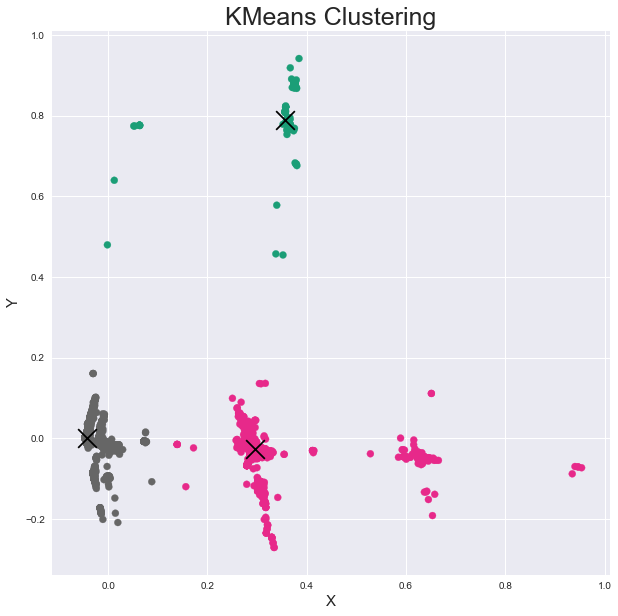

In [614]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10, n_jobs = -1) # n_init, number of times the K-mean algorithm will run
labels = km.fit_predict(data)

pca = PCA(n_components=2)
pcafeatures_train = pca.fit_transform(data)


plt.figure(figsize=[10,10])
plt.scatter(pcafeatures_train[:,0], pcafeatures_train[:,1], c=labels, cmap = 'Dark2_r')

centroids = pca.transform(km.cluster_centers_)

plt.scatter(centroids[:,0], centroids[:,1], c='black', marker ='x', s= 350)
plt.title('KMeans Clustering', fontsize=25)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.savefig("clustering", format='png', transparent=True)

In [477]:
doc_topic_df = doc_topic_df.rename(columns={'topic 0': 'NBA Teams', 'topic 1': 'D\'lo Stats', 'topic 2': 'Golden State', 
                                            'topic 3': 'Chase Center', 'topic 4': 'Highlights', 'topic 5': 'Warriors Players',
                                            'topic 6': 'Sports Bets', 'topic 7': 'Loyal Fans'})

In [613]:
doc_topic_df

,NBA Teams,D'lo Stats,Golden State,Chase Center,Highlights,Warriors Players,Sports Bets,Loyal Fans
0,0.000000,0.000000,0.000058,0.000131,0.0,0.000000,0.0,0.000174
1,0.128849,0.000000,0.009291,0.000273,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000684,0.002212,0.000603,0.0,0.013054,0.0,0.003105
...,...,...,...,...,...,...,...,...
74221,0.002517,0.000000,0.113136,0.000000,0.0,0.000000,0.0,0.000000
74222,0.000000,0.000000,0.002699,0.003261,0.0,0.002057,0.0,0.001895
74223,0.000003,0.000152,0.000000,0.000000,0.0,0.000032,0.0,0.000000
74224,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


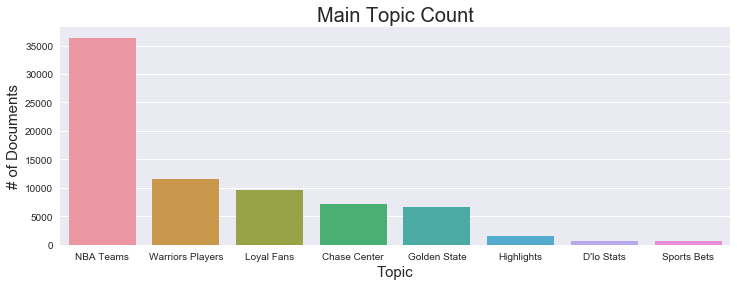

In [620]:
topic_counts = doc_topic_df.idxmax(axis = 1).value_counts()
plt.figure(figsize=[12,4])
sns.barplot(topic_counts.index, topic_counts.values)
plt.xlabel('Topic', fontsize = 15)
plt.ylabel('# of Documents', fontsize = 15)
plt.title('Main Topic Count', fontsize = 20)
plt.savefig("topic_count", format='png', transparent=True)

In [541]:
tweet_df = tweet_df.reset_index()

In [549]:
main_topic = pd.DataFrame(doc_topic_df.idxmax(axis = 1)).join(tweet_df)
main_topic = main_topic.rename(columns = {0:'topic'})

In [550]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
scores = []
for doc in main_topic['text']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [551]:
scores_ = pd.DataFrame(scores)

In [552]:
sentiment_df = pd.concat([main_topic, scores_], axis=1)

In [553]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [422]:
topic0 = sentiment_df[sentiment_df['topic']=='topic 0']
topic1 = sentiment_df[sentiment_df['topic']=='topic 1']
topic2 = sentiment_df[sentiment_df['topic']=='topic 2']
topic3 = sentiment_df[sentiment_df['topic']=='topic 3']
topic4 = sentiment_df[sentiment_df['topic']=='topic 4']
topic5 = sentiment_df[sentiment_df['topic']=='topic 5']
topic6 = sentiment_df[sentiment_df['topic']=='topic 6']
topic7 = sentiment_df[sentiment_df['topic']=='topic 7']


In [558]:
plot_df = sentiment_df.groupby(['topic']).resample('w', on='date').mean()

In [569]:
colors = ['seagreen', 'navy', 'darkorchid', 'springgreen', 'purple', 'gray', 'fuchsia', 'firebrick']

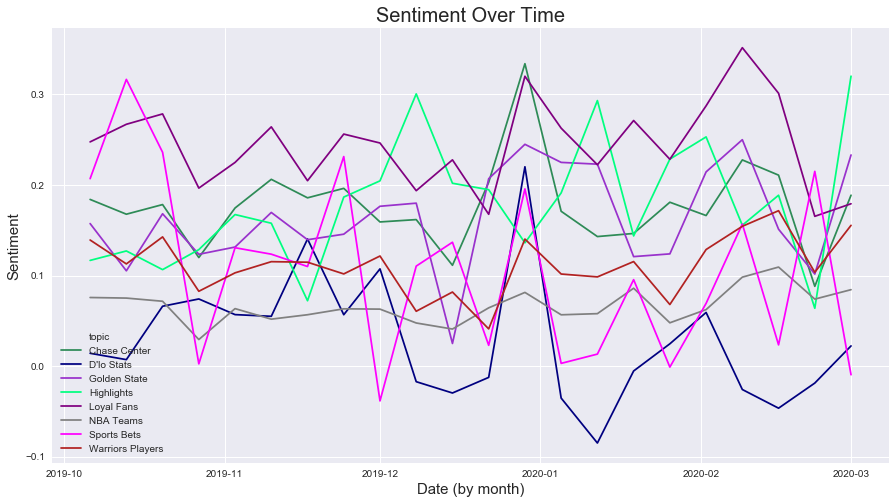

In [621]:
plt.figure(figsize=(15,8))
sns.lineplot(data = plot_df.reset_index(), 
              x='date', y='compound', hue='topic', palette = sns.color_palette(colors, desat=1))
plt.legend(loc='lower left')
plt.xlabel('Date (by month)', fontsize = 15)
plt.ylabel('Sentiment', fontsize = 15)
plt.title('Sentiment Over Time', fontsize = 20)
plt.savefig("sentiment1", format='png', transparent=True)

In [580]:
plot2 = plot_df.loc[['Loyal Fans', 'Chase Center', 'D\'lo Stats']]

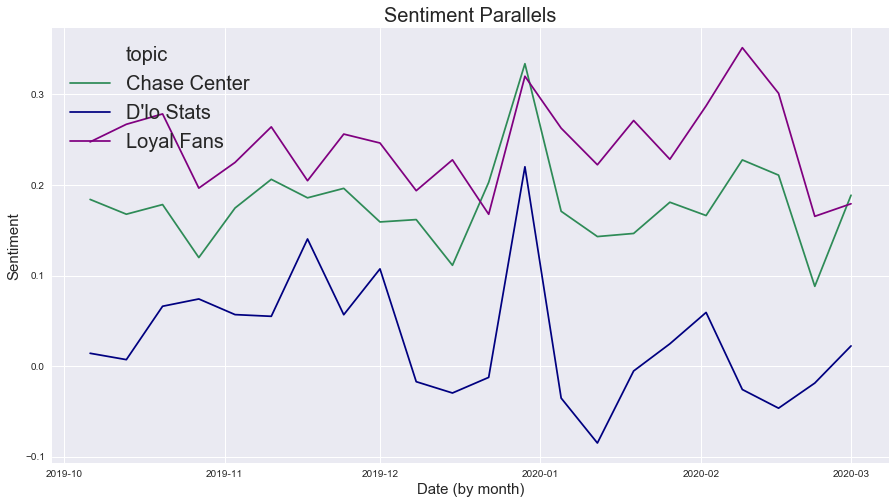

In [622]:
plt.figure(figsize=(15,8))
sns.lineplot(data = plot2.reset_index(), 
              x='date', y='compound', hue='topic', palette = sns.color_palette([colors[0], colors[1], colors[4]], desat=1))
plt.legend(fontsize = 20, loc='upper left')
plt.xlabel('Date (by month)', fontsize = 15)
plt.ylabel('Sentiment', fontsize = 15)
plt.title('Sentiment Parallels', fontsize = 20)
plt.savefig("sentiment2", format='png', transparent=True)

In [605]:
plot3 = plot_df.loc[['D\'lo Stats', 'Highlights']]

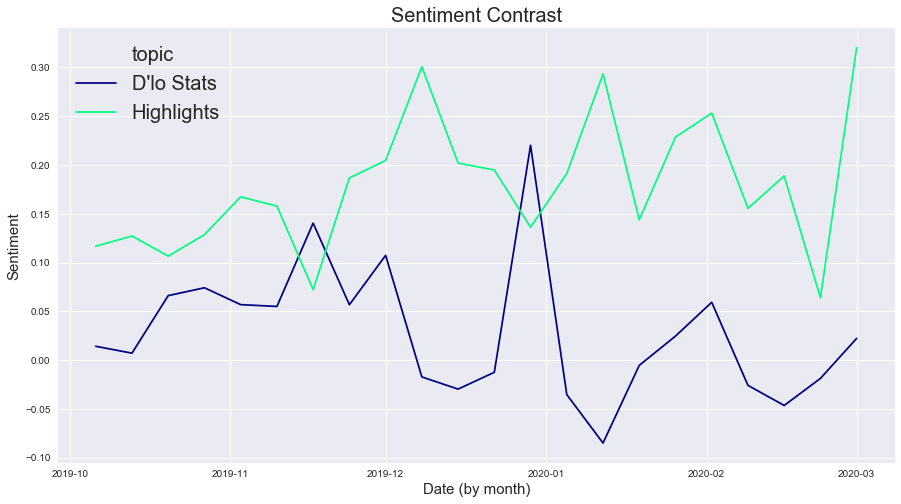

In [623]:
plt.figure(figsize=(15,8))
sns.lineplot(data = plot3.reset_index(), 
              x='date', y='compound', hue='topic', palette = sns.color_palette([colors[1], colors[3]], desat=1))
plt.legend(fontsize = 20, loc='upper left')
plt.xlabel('Date (by month)', fontsize = 15)
plt.ylabel('Sentiment', fontsize = 15)
plt.title('Sentiment Contrast', fontsize = 20)
plt.savefig("sentiment3", format='png', transparent=True)